(section:edge_attention)=
# Edge-Enhanced Attention GCN
## Edge-Enhanced Attention GNN definition

We would now like to make use of edge features in our model, as we are for now completely missing out on these additional predictors.

To this end, we will use a custom approach inspired by the [Exploiting Edge Features for Graph Neural Networks](https://ieeexplore.ieee.org/document/8954414/) paper by Gong and Cheng, 2019.

We will adapt their Attention-based edge-enhanced neural network, termed **EGNN(A)**, by redefining our Attention layer in the following way :
    
* Compute the attention score $\alpha^l_{ij}$ separately for each feature dimension $p$ such that: 
   
   $\alpha^l_{ijp} = f^l(X^{l-1}_i, X^{l-1}_j) \cdot  E^{l-1}_{ijp}$
   
   In this, $f^l$ is our previously used formula for the attention score (scalar) and $X^{l-1}$ the output of the previous layer. 
   
   Here we simply compute the dot product with the edge feature matrix $E$ of shape $N \times N \times E_{feat}$.

*  Replace their proposed Double Stochastic Normalization with Group normalization for simplicity. 
   We only have to ensure that the channel dimension corresponds to the edge features before normalizing; we will select the number of groups as a hyperparameter.

*  The obtained edge-enhanced attention score $\alpha^l$ of shape $N \times N \times E_{feat}$ is then used as the edge features $E^l$ in the next layer as they suggest, i.e. $E^{l} = \alpha^l$
  
*  Then, not unlike multi-head attention (but with edge feature-specific heads instead of randomly initialized heads using the same input data), we concatenate on the edge feature dimension and feed the result to a fully-connected layer.
   
   With this we obtain $A^l$ of shape $B \times N \times N$ :
   
   $A^l_{ij} = a_{ij} \vert \vert_{p=1}^P  \alpha_{ijp}^l$ 
   
   where $a$ is a learnable weight of shape $(E_{feat} N) \times N$ and $\vert \vert$ is the concatenation operator.

* Finally, the output is obtained by multiplying $A^l$ with the support $X^{l-1} W^l$ and applying the activation function: 
  
  $X^l = \sigma (A^l X^{l-1} W^l)$

* We return $X^l$ and $E^l$, to be used by the next layer.

## Validating our model

In order to show that our proposed architecture is indeed an improvement, we perform some simple checks to make sure that our edge features and the Group normalization are actually helpful.

We will compare performance when :

* Setting the edge feature matrix $E^l$ to ones
* Setting the edge-enhanced attention matrix $A^l$ to ones before multiplying with the support 
* Removing the Group normalization

Results can be seen in {ref}`section:edgeattgcn_validation`.

In [1]:
import warnings
import os
from sys import path

warnings.filterwarnings(
    "ignore"
)  # ignore warnings from missing deterministic implementation. These are strictly from wandb and do not affect the reproducibility of the actual runs.
os.environ[
    "WANDB_NOTEBOOK_NAME"
] = "EdgeAttentionGCN.ipynb"  # name the notebook for wandb tracking
path.append("../code")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import model as m
import training as t
import utils
import logging
import sys
from utils import LOG as logger

logging.basicConfig(
    format="%(message)s", level=logging.INFO, stream=sys.stdout
)
logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)

# t.WANDB_MODE = "disabled"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dataloaders, dataset = t.create_dataloaders(
    batch_size=20,
    use_edge_features=True,
    # train_split=0.5,
)

Length of train set: 131
Length of validation set: 28
Length of test set: 29


## Training
### Model

In [5]:
node_features = dataset.node_features.shape[2]
conv_dims = [256, 256, 128, 64]
model = m.EdgeAttentionGCN(
    num_features=node_features,
    conv_dims=conv_dims,
    # fcn_layers=[128],
    activation=nn.LeakyReLU(),
    dropout=0.3,
    pooling="max",
    norm=nn.BatchNorm1d,
)

# utils._print_gradient_hook(model)


print(model)

Initialized model with 4 graph conv layers
Initialized model with 1 fully connected layers
EdgeAttentionGCN(
  (convs_layers): ModuleList(
    (0): EdgeConv(
      (weight): Linear(in_features=7, out_features=256, bias=False)
      (S): Linear(in_features=512, out_features=28, bias=False)
      (edge_layer): Linear(in_features=112, out_features=28, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (att_activation): LeakyReLU(negative_slope=0.1)
      (softmax): Softmax(dim=1)
      (instance_norm): GroupNorm(4, 4, eps=1e-05, affine=True)
    )
    (1): EdgeConv(
      (weight): Linear(in_features=256, out_features=256, bias=False)
      (S): Linear(in_features=512, out_features=28, bias=False)
      (edge_layer): Linear(in_features=112, out_features=28, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (att_activation): LeakyReLU(negative_slope=0.1)
      (softmax): Softmax(dim=1)
      (instance_norm): GroupNorm(4, 4, eps=1e-05, affine=True)
    )

### Training parameters

In [6]:
epochs = 200 # this model converges much faster than the others
learning_rate = 1e-4 # it also benefits from a lower learning rate

model.to(DEVICE)

label_counts = dataset[:]["class_y"].unique(return_counts=True)[1]
pos_weight = label_counts[0] / label_counts[1]

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": 0,
    "loss": [],
    "acc": [],
    "val-roc": [],
    "val-ap": [],
}

### Training loop

In [7]:
history = t.train_loop(
    history=history,
    train_dataloader=dataloaders[0],
    val_dataloader=dataloaders[1],
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=DEVICE,
    use_scheduler=False,
    test_dataloader=dataloaders[2],
    use_edges=True,
)

wandb: Currently logged in as: c-achard. Use `wandb login --relogin` to force relogin


Epoch   1/200:Epoch loss: 0.8547 - avg acc: 30.5% - val-roc: 0.7551 - val-ap: 0.7927 (0.5s/epoch)
Epoch   2/200:Epoch loss: 0.8229 - avg acc: 30.5% - val-roc: 0.8367 - val-ap: 0.8719 (0.1s/epoch)
Epoch   3/200:Epoch loss: 0.6942 - avg acc: 30.5% - val-roc: 0.8571 - val-ap: 0.9011 (0.2s/epoch)
Epoch   4/200:Epoch loss: 0.6281 - avg acc: 30.5% - val-roc: 0.8520 - val-ap: 0.9025 (0.2s/epoch)
Epoch   5/200:Epoch loss: 0.5854 - avg acc: 30.5% - val-roc: 0.8367 - val-ap: 0.8865 (0.2s/epoch)
Epoch   6/200:Epoch loss: 0.4621 - avg acc: 30.5% - val-roc: 0.7857 - val-ap: 0.8465 (0.2s/epoch)
Epoch   7/200:Epoch loss: 0.4798 - avg acc: 30.5% - val-roc: 0.7398 - val-ap: 0.8151 (0.1s/epoch)
Epoch   8/200:Epoch loss: 0.4373 - avg acc: 31.3% - val-roc: 0.7347 - val-ap: 0.8136 (0.1s/epoch)
Epoch   9/200:Epoch loss: 0.3781 - avg acc: 32.1% - val-roc: 0.7347 - val-ap: 0.8104 (0.1s/epoch)
Epoch  10/200:Epoch loss: 0.4047 - avg acc: 33.6% - val-roc: 0.7857 - val-ap: 0.8379 (0.1s/epoch)
Epoch  11/200:Epoch 

epoch_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/test_ap,▁
test/test_roc,▁
train_acc,▁▁▂▂▂▂▃▃▃▄▅▅▆▆▇▇▇▇▇▇█▇▇█████████████████
train_loss,▅▇█▅▅▄▂▅▂▁▂▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▂▁▁▁▁▁
val/val_ap,▇▅▄▃▁▃▄▆▇▇█▇▇▇█▇▆█▇▅▅▄▄▃▅▇▆▇▆▆▅▆▆▆▆▅▅▅▅▅
val/val_roc,▄▁▂▂▁▂▄▆▇▇██▇▇█▇▆█▇▆▅▆▆▅▆▇▆▇▆▆▆▆▆▇▆▆▆▅▅▆
epoch_loss,0.00144
test/test_ap,0.96487
test/test_roc,0.91111
train_acc,100.0


### Plots of training history

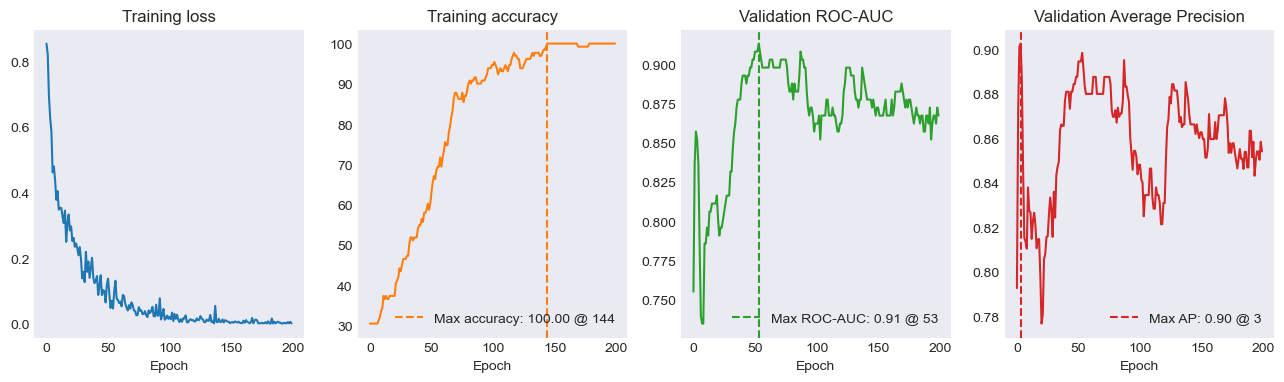

In [8]:
utils.plot_history(history)

## Validation on unseen data

Test ROC-AUC: 0.9111
Test AP: 0.9649


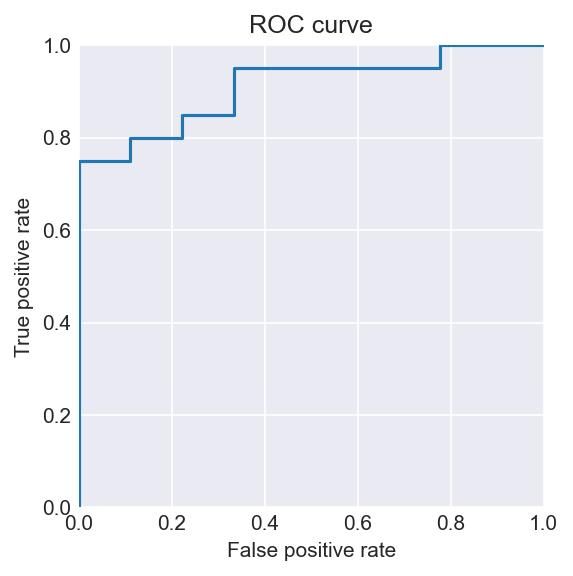

Number of correct positive predictions on test set: 17 out of 20
Number of correct negative predictions on test set: 6 out of 9


In [9]:
test_roc, test_ap, preds, ys = t.test(
    dataloaders[2].dataset, model, return_preds=True
)
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataloaders[2].dataset, model)
print(
    f"Number of correct positive predictions on test set: {torch.sum((preds > 0.5) & (ys == 1)).numpy()} out of {torch.sum(ys == 1).numpy()}"
)
print(
    f"Number of correct negative predictions on test set: {torch.sum((preds < 0.5) & (ys == 0)).numpy()} out of {torch.sum(ys == 0).numpy()}"
)

## Full dataset performance
We now check how the model performs overall on the whole dataset.
We also check which molecules are not properly labeled, as well as the distribution of predictions to get a sense of the model's (un)certainty.

In [10]:
data_all = t.create_dataset_dict(add_edge_features=True)
full_dataset = t.MutagDataset(data_all)

### Full ROC curve

Full ROC-AUC: 0.9792
Full AP: 0.9878


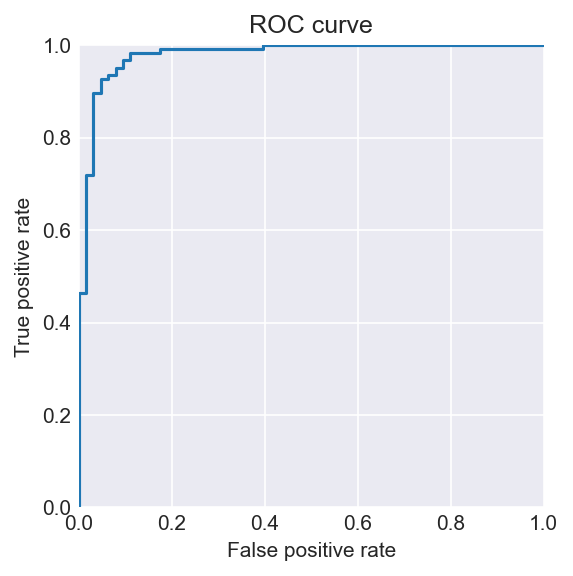

Number of correct positive predictions on test set: 117 out of 125
Number of correct negative predictions on test set: 58 out of 63


In [11]:
full_roc, full_ap, preds, ys = t.test(dataset, model, return_preds=True)
print(f"Full ROC-AUC: {full_roc:.4f}")
print(f"Full AP: {full_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataset, model)

preds = preds.cpu().detach().numpy()
ys = ys.cpu().detach().numpy()
print(
    f"Number of correct positive predictions on test set: {np.sum((preds > 0.5) & (ys == 1))} out of {np.sum(ys == 1)}"
)
print(
    f"Number of correct negative predictions on test set: {np.sum((preds < 0.5) & (ys == 0))} out of {np.sum(ys == 0)}"
)

### Predictions distribution

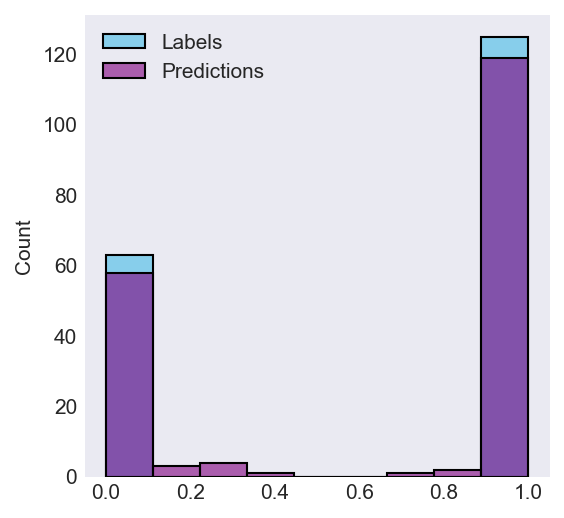

This plot shows the distribution of the labels and predictions; predictions are overlayed on top of the labels, showing whether they are missing or surnumerous.
The labels are 125 positive and 63 negative.
The predictions are 122 positive and 66 negative.


In [12]:
utils.show_preds_distribution(preds, ys)

### Confusion matrix

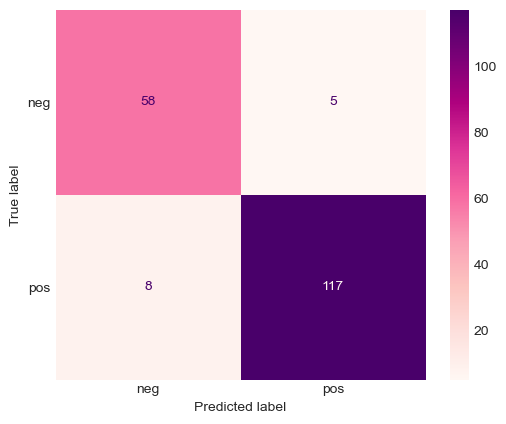

In [13]:
utils.plot_confusion_matrix(preds, ys)

### Check mislabelled molecules

13 mislabeled molecules


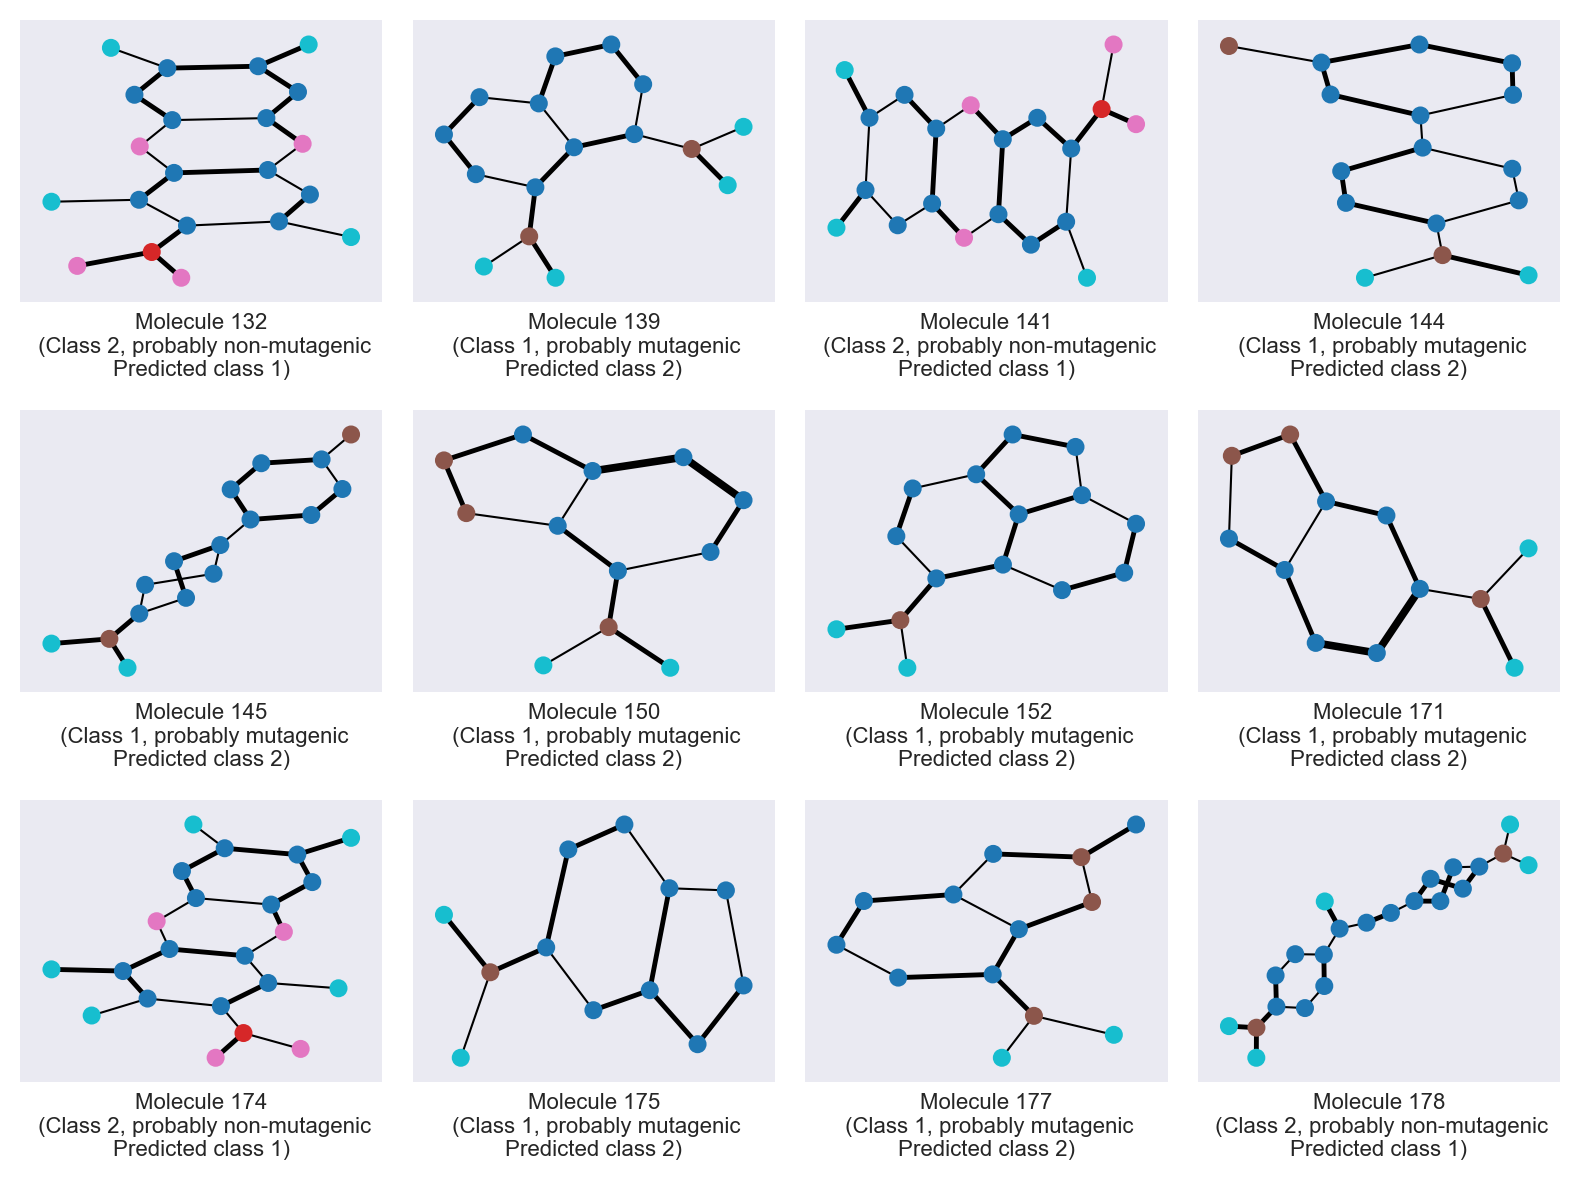

In [14]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:12],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=4,
    n_rows=3,
    figsize=(8, 6),
)